In [1]:
from google.colab import drive
import os
drive.flush_and_unmount()
drive.mount('/content/gdrive')#force_remount=True
root_path = "/content/gdrive/My Drive/sims-projs-gdrive/cfd_unet_hennigh/"  #change dir to your project folder
#sys.path.append(os.path.abspath(root_path))
os.chdir(root_path)
#from google.colab import drive
#drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from pysim import config
from pysim import u_resnet_arch
import build_dataset
from tensorflow import keras
K = keras.backend
import pandas as pd
import argparse
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

/content/gdrive/My Drive/datasets/cfd_hennigh/train /content/gdrive/My Drive/datasets/cfd_hennigh/val /content/gdrive/My Drive/datasets/cfd_hennigh/test
Original data: /content/gdrive/My Drive/datasets/cfd_hennigh
INFO: This data is saved as tf.records so no further processing is done on disk.
Folders /content/gdrive/My Drive/datasets/cfd_hennigh/train /content/gdrive/My Drive/datasets/cfd_hennigh/val /content/gdrive/My Drive/datasets/cfd_hennigh/test will not be created.
INFO: Further data processing is done on the fly.
Following file is processed: data.tfrecords
INFO: TFRecords file was parsed, and prepared for shuffling/batching!!!
INFO: There are 3012 samples in dataset!!!


In [3]:
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", type=str, default="models/model_5.h5", help="path to trained model")
ap.add_argument("-p", "--plots", type=str, default="plots/",help="path to output plots")
args = vars(ap.parse_args([]))
plots_path = args["plots"]

In [8]:
#load pretrained model from disk
print("[INFO] loading pre-trained network...")
def CFD_Metric(threshold = 0.15):
    def cfd_image(y_true, y_pred):
      threshold = 0.15
      error = tf.abs(y_true[:, :] - y_pred[:, :])/(tf.abs(y_pred[:, :]) + 1e-10)
      is_small_error = error <= threshold
      return (tf.where(is_small_error, 0, 1))
    return cfd_image

custom_objects={"CFD_Metric": CFD_Metric(0.15)}
model = tf.keras.models.load_model(args["model"], custom_objects = {"cfd_image": CFD_Metric()})
print("..done")

[INFO] loading pre-trained network...
..done


In [9]:
# Load data/images for which we want to evaluate predictions!
# this are saved on disk as tfrecords anad are loaded via import build_dataset
train_dataset = build_dataset.train_dataset
val_dataset   = build_dataset.val_dataset
test_dataset  = build_dataset.test_dataset

In [5]:
def mse_img(imgA, imgB):
    shape = imgA.shape # image shape (height, width, channels)
    squared_diff = np.square(imgA[:, :] - imgB[:, :])
    return np.sum(squared_diff)/(shape[0] * shape[1]) 


def img_perc_error(imgA, imgB, epsilon):
    shape = imgA.shape
    error = np.abs(imgA[:, :] - imgB[:, :])/(np.abs(imgB[:, :]) + 1e-10)
    is_small_error = error <= epsilon
    imgError = np.where(is_small_error, 0, 1)
    sum_tot = np.sum(imgB)/(shape[0] * shape[1]) 
    return imgError

In [6]:
# this is to be put in 

  # this is to be put in 
def montage_testing_v00(boundary, sflow, counter, epsilon):
#boundary, sflow = next(iter(train_dataset))
  data_shape = boundary.shape
  proto_boundary = tf.make_tensor_proto(boundary)  # convert `tensor a` to a proto tensor
  b = tf.make_ndarray(proto_boundary)
  b = np.reshape(b, data_shape[:3])

  proto_sflow = tf.make_tensor_proto(sflow)  # convert `tensor a` to a proto tensor
  sflow = tf.make_ndarray(proto_sflow)
  sflow_x = np.reshape(sflow[:, :, :, 0], data_shape[:3])
  sflow_y = np.reshape(sflow[:, :, :, 1], data_shape[:3])

  sflow_pred = model.predict(b)  
  sflow_predx = sflow_pred[:, :, :, 0]
  sflow_predx = np.reshape(sflow_predx, data_shape[:3]) 
  sflow_predy = sflow_pred[:, :, :, 1] 
  sflow_predy = np.reshape(sflow_predy, data_shape[:3]) 
  predx_error = (sflow_predx - sflow_x)                                        
  predy_error = (sflow_predy - sflow_y)
  batch_b_sx_sy = ()  
  for j in range(1):
    mse_x =  mse_img(sflow_predx[j, :, :], sflow_x[j, :, :]) 
    mse_y =  mse_img(sflow_predy[j, :, :], sflow_y[j, :, :])
    print("MSE_x:", mse_x)
    print("MSE_y:", mse_y)
    img_perErrorX= img_perc_error(sflow_x[j, :, :], sflow_predx[j, :, :], epsilon)
    img_perErrorY= img_perc_error(sflow_y[j, :, :], sflow_predy[j, :, :], epsilon)
    batch_b_sx_sy = batch_b_sx_sy + (
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("x-Vel", sflow_x[j, :, :]), \
                                     ("y-Vel", sflow_y[j, :, :]) ,                                    
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("Pred. x-Vel", sflow_predx[j, :, :]), \
                                     ("Pred. y-Vel", sflow_predy[j, :, :]),
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("Error x-Vel",  predx_error[j, :, :]), \
                                     ("Error y-Vel",  predy_error[j, :, :]),\
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("Per. Error x-Vel .gt. {:.2f}".format(epsilon),  img_perErrorX[:, :]), \
                                     ("Per. Error x-Vel .gt. {:.2f}".format(epsilon),  img_perErrorY[:, :])                                      

                                     )
  fig = plt.figure() 
  fig1, axs1 = plt.subplots(2, 3, figsize = (14, 4))#, constrained_layout=True)
#fig = plt.figure(figsize = (12, 7))
  for i, ax in enumerate(axs1.flat):
    for (j, (name, image)) in enumerate(batch_b_sx_sy[:-3]):
    #print(i, name, image.shape)
      if (i == j): 
        pcm1 = axs1.flat[i].imshow(image, cmap = "jet", vmin= -0.1, vmax = 0.2)
        axs1.flat[i].set_title(name) 
        axs1.flat[i].axis("off") 
  fig1.colorbar(pcm1, ax=axs1[:2, :], location='right', shrink=0.8)
  fig2, axs2 = plt.subplots(1, 3, figsize = (14, 6), squeeze=False)#, constrained_layout=True)
  for i, ax in enumerate(axs2.flat):
    for (j, (name, image)) in enumerate(batch_b_sx_sy[6:9]):
      if (i == j): 
        pcm2 = axs2.flat[i].imshow(image, cmap = "jet", vmin= 1e-5, vmax =1e-2)
        axs2.flat[i].set_title(name) 
        axs2.flat[i].axis("off") 
    #if i == 0:
        #axs2.flat[i].set_visible(False)   
#axs2[0].get_xaxis().set_visible(True)  
#fig2.delaxes(axs2.flatten()[1],)
  fig2.colorbar(pcm2, ax=axs2[:], location='right', shrink=0.4)

  fig3, axs3 = plt.subplots(1, 3, figsize = (15, 6), squeeze=False)#, constrained_layout=True)
  for i, ax in enumerate(axs3.flat):
    for (j, (name, image)) in enumerate(batch_b_sx_sy[9:]):
      if (i == j): 
        pcm3 = axs3.flat[i].imshow(image, cmap = "Greys")#, vmin= 0, vmax =1)
        axs3.flat[i].set_title(name) 
        axs3.flat[i].axis("off") 
    #if i == 0:
        #axs2.flat[i].set_visible(False)   
#axs2[0].get_xaxis().set_visible(True)  
#fig2.delaxes(axs2.flatten()[1],)
  fig3.colorbar(pcm3, ax=axs3[:], location='right', shrink=0.4)

  #plt.savefig("TEST_"+"{:02d}".format(counter) +".png")
  #plt.imsave("montage_test_pred_"+"{:02d}".format(counter) +".png", pcm1)
  pp = PdfPages(args["plots"] + "montage_test_pred_"+"{:02d}".format(counter) +".png", )
  #plt.tight_layout()
  pp.savefig(fig1, dpi = 300, transparent = True)
  pp.savefig(fig2, dpi = 300, transparent = True)
  pp.savefig(fig3, dpi = 300, transparent = True)
  pp.close()
  return 



#NO_OF_PICS = 1
#plots_path = args["plots"] 
#for counter in range(NO_OF_PICS):
#  boundary, sflow = next(iter(test_dataset))
#  montage_testing(boundary, sflow, counter, 0.10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


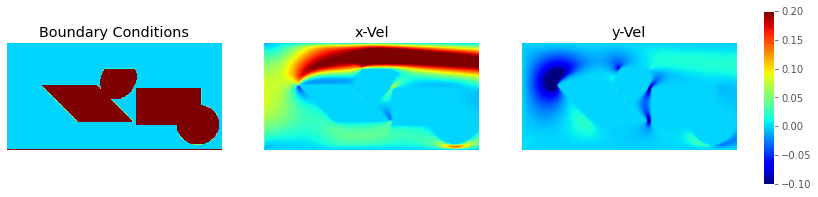

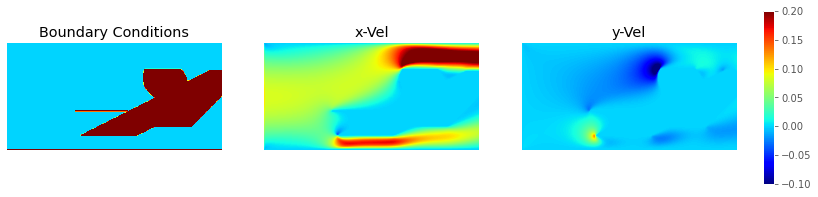

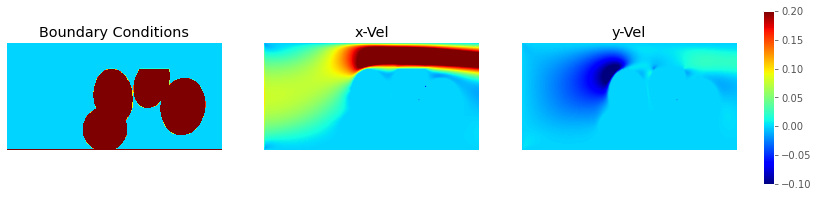

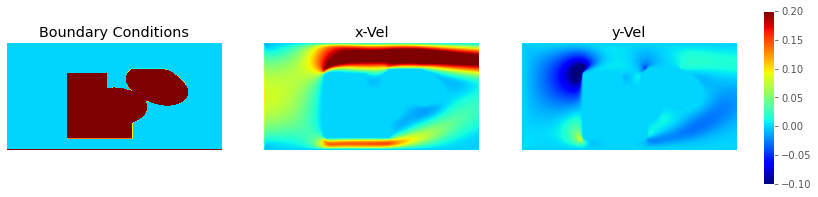

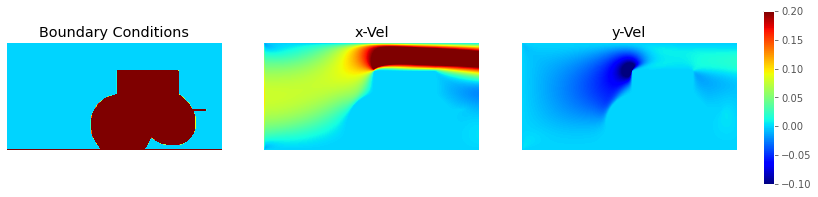

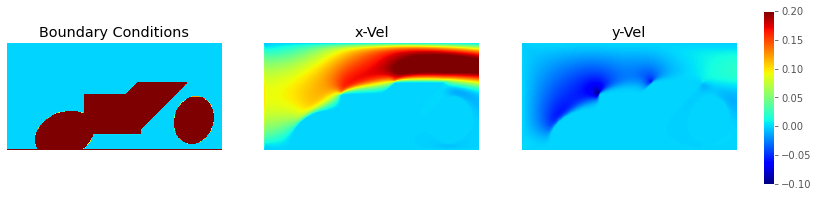

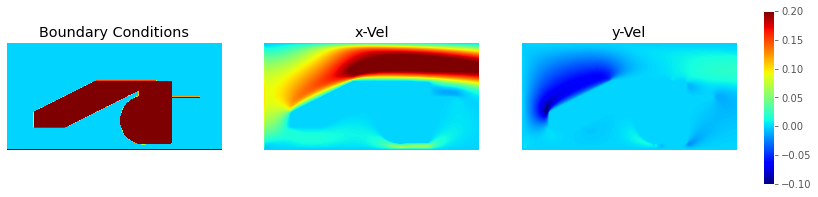

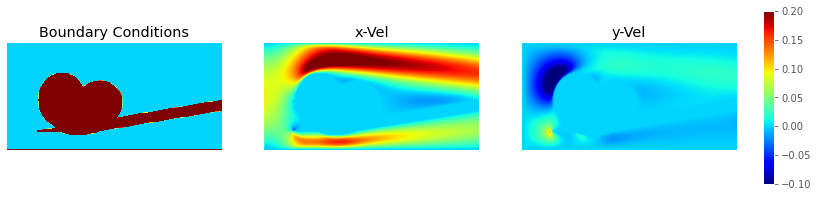

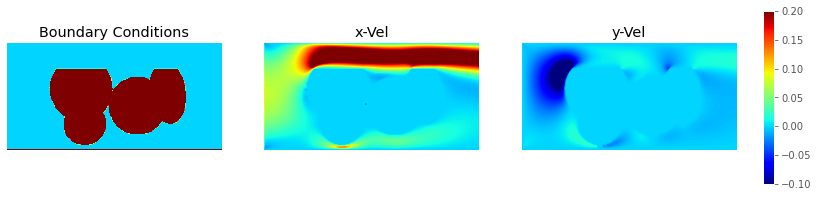

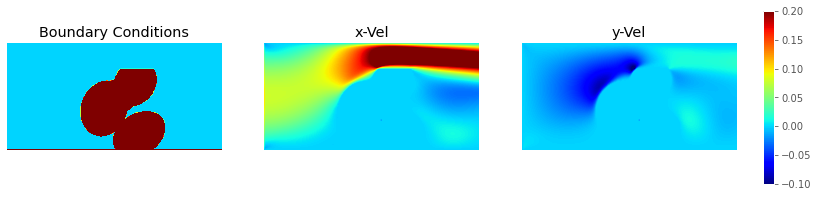

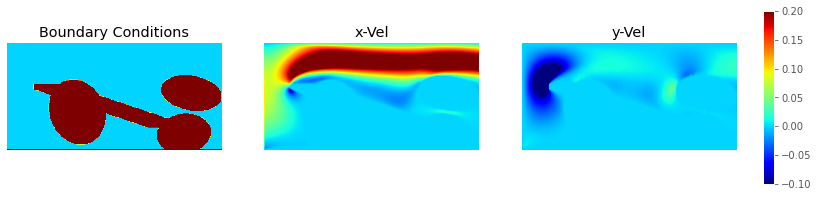

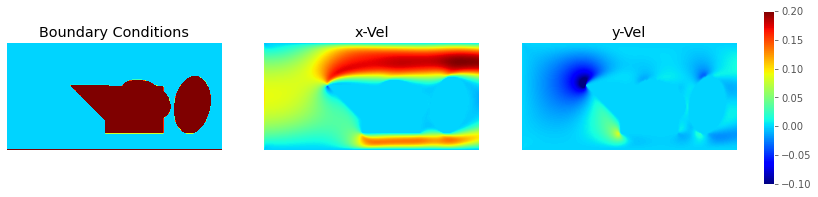

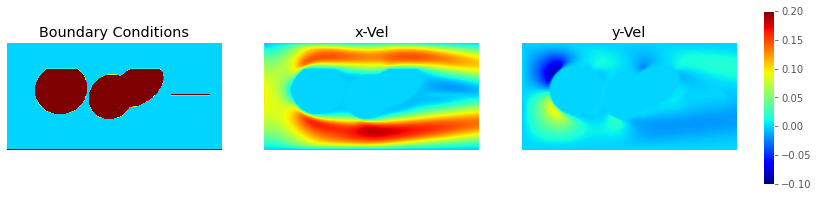

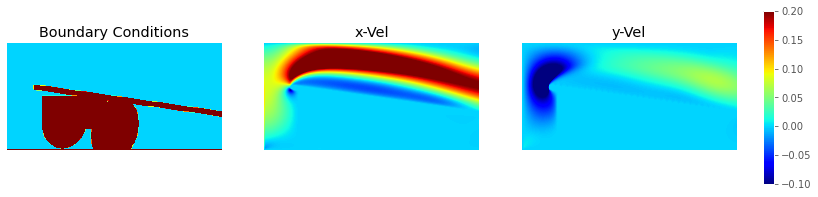

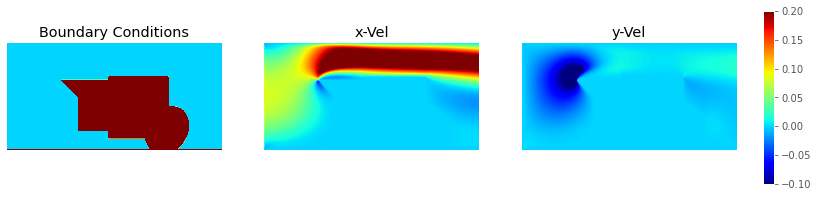

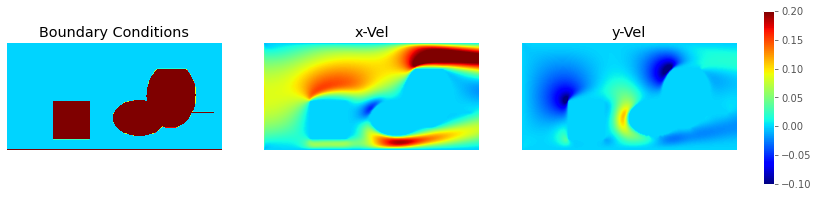

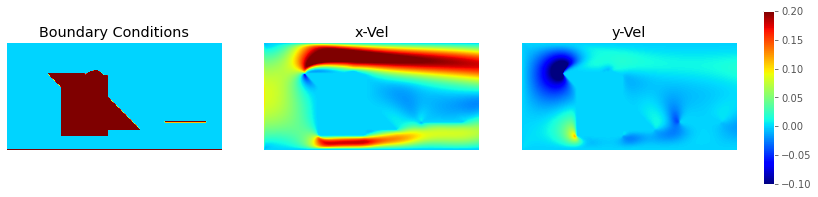

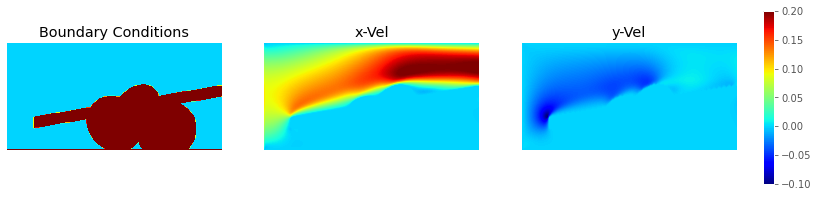

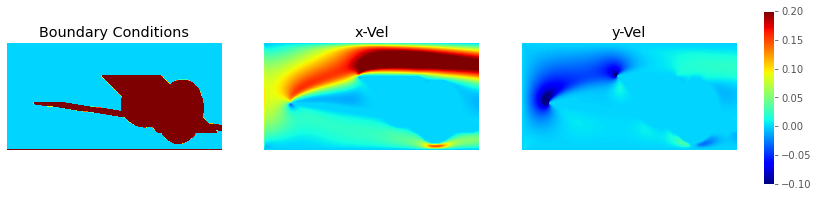

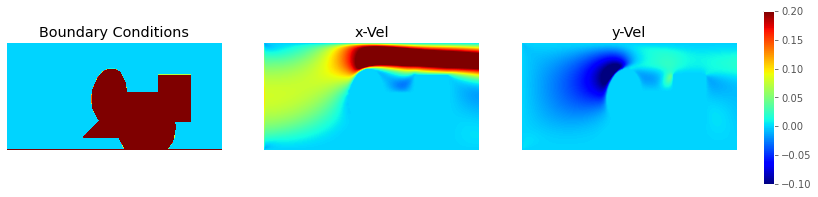

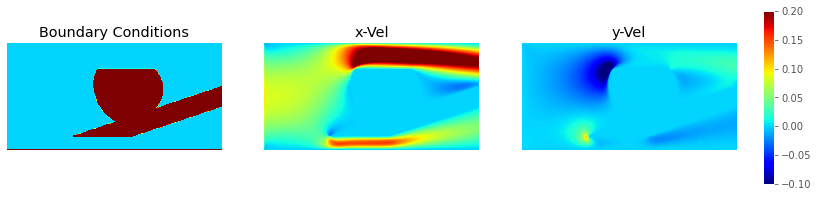

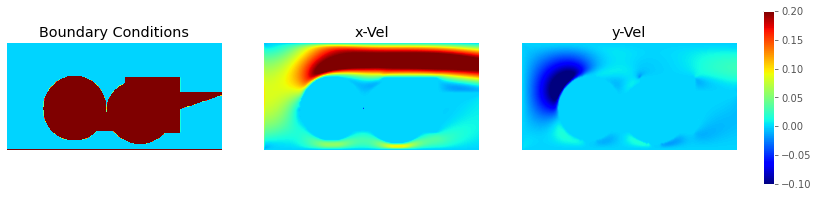

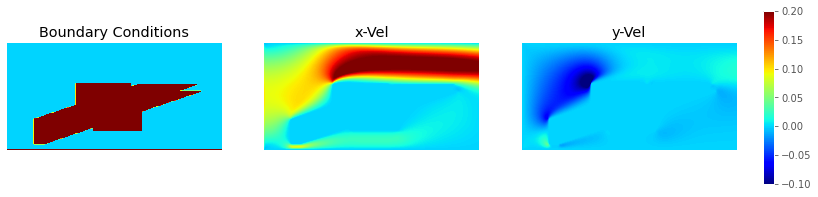

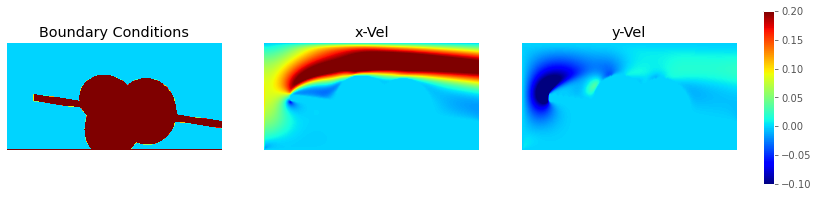

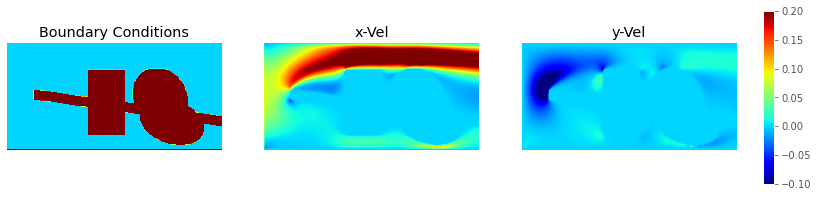

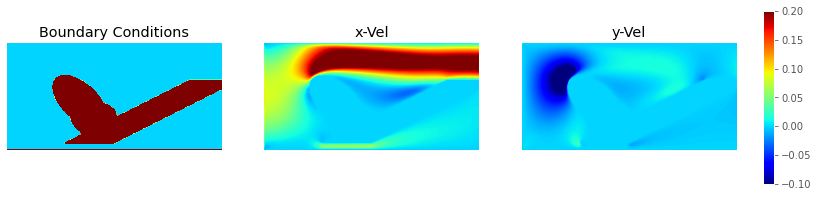

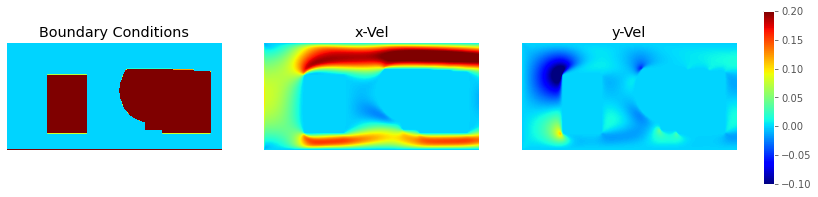

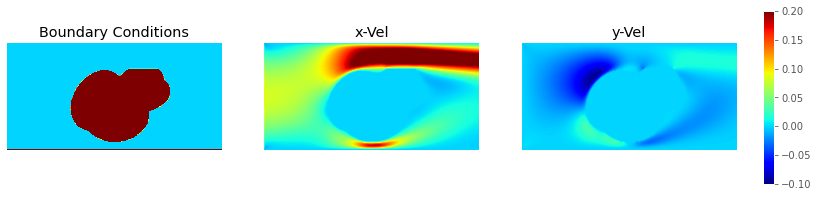

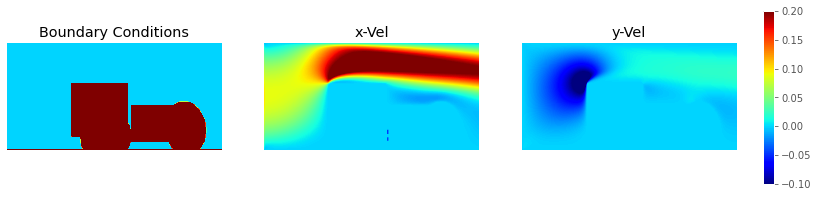

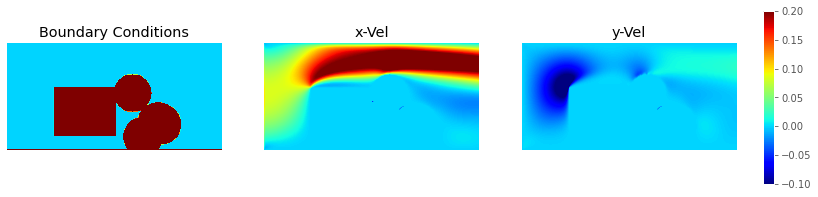

In [ ]:
def montage_training(boundary, sflow, counter, epsilon):
#boundary, sflow = next(iter(train_dataset))
  data_shape = boundary.shape
  proto_boundary = tf.make_tensor_proto(boundary)  # convert `tensor a` to a proto tensor
  b = tf.make_ndarray(proto_boundary)
  b = np.reshape(b, data_shape[:3])
  proto_sflow = tf.make_tensor_proto(sflow)  # convert `tensor a` to a proto tensor
  sflow = tf.make_ndarray(proto_sflow)

  sflow_x = np.reshape(sflow[:, :, :, 0], data_shape[:3])
  sflow_y = np.reshape(sflow[:, :, :, 1], data_shape[:3])
  batch_b_sx_sy = () 
  no_pics = 1
  for j in range(no_pics):
    batch_b_sx_sy = batch_b_sx_sy + (
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("x-Vel", sflow_x[j, :, :]), \
                                     ("y-Vel", sflow_y[j, :, :]) ,                                                                                                                
                                     )
#v = np.linspace(-1.0, 1.0, 15, endpoint=True)   
# loop over the images
  fig = plt.figure(figsize = (15, 3))
  for (i, (name, image)) in enumerate(batch_b_sx_sy):
    # show the image
    ax = fig.add_subplot(no_pics,3, i + 1)
    ax.set_title(name)    
    image = np.reshape(image, data_shape[1:3])
    plt.imshow(image, cmap = "jet", vmin= -0.1, vmax = 0.2)
    #plt.colorbar(ticks=v, fraction = 0.03, pad=0.14)
    plt.axis("off")   
  plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
  cax = plt.axes([0.825, 0.095, 0.01, 0.80])
  plt.colorbar(cax=cax, fraction = 0.01) 
  plt.savefig(args["plots"]+ "montage_train_data_"+"{:02d}".format(counter) +".png", dpi = 900) 
  return



NO_OF_PICS = 30
for counter in range(NO_OF_PICS):
    boundary, sflow = next(iter(train_dataset))
    montage_training(boundary, sflow, counter, 0.10)

In [ ]:
# this is to be put in 

  # this is to be put in 
def montage_testing(boundary, sflow, counter, epsilon):
#boundary, sflow = next(iter(train_dataset))
  data_shape = boundary.shape
  proto_boundary = tf.make_tensor_proto(boundary)  # convert `tensor a` to a proto tensor
  b = tf.make_ndarray(proto_boundary)
  b = np.reshape(b, data_shape[:3])

  proto_sflow = tf.make_tensor_proto(sflow)  # convert `tensor a` to a proto tensor
  sflow = tf.make_ndarray(proto_sflow)
  sflow_x = np.reshape(sflow[:, :, :, 0], data_shape[:3])
  sflow_y = np.reshape(sflow[:, :, :, 1], data_shape[:3])

  sflow_pred = model.predict(b)  
  sflow_predx = sflow_pred[:, :, :, 0]
  sflow_predx = np.reshape(sflow_predx, data_shape[:3]) 
  sflow_predy = sflow_pred[:, :, :, 1] 
  sflow_predy = np.reshape(sflow_predy, data_shape[:3]) 
  predx_error = np.abs(sflow_predx - sflow_x)                                        
  predy_error = np.abs(sflow_predy - sflow_y)
  batch_b_sx_sy = ()  
  for j in range(1):
    mse_x =  mse_img(sflow_predx[j, :, :], sflow_x[j, :, :]) 
    mse_y =  mse_img(sflow_predy[j, :, :], sflow_y[j, :, :])
    #print("MSE_x:", mse_x)
    #print("MSE_y:", mse_y)
    img_perErrorX= img_perc_error(sflow_x[j, :, :], sflow_predx[j, :, :], epsilon)
    img_perErrorY= img_perc_error(sflow_y[j, :, :], sflow_predy[j, :, :], epsilon)
    batch_b_sx_sy = batch_b_sx_sy + (
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("x-Vel", sflow_x[j, :, :]), \
                                     ("y-Vel", sflow_y[j, :, :]) ,                                    
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("Pred. x-Vel", sflow_predx[j, :, :]), \
                                     ("Pred. y-Vel", sflow_predy[j, :, :]),
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("Error x-Vel",  predx_error[j, :, :]), \
                                     ("Error y-Vel",  predy_error[j, :, :]),\
                                     ("Boundary Conditions", b[j,:,:]), \
                                     ("Per. Error x-Vel .gt. {:.2f}".format(epsilon),  img_perErrorX[:, :]), \
                                     ("Per. Error x-Vel .gt. {:.2f}".format(epsilon),  img_perErrorY[:, :])                                      
                                     )
  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12))= plt.subplots(4,3, figsize=(10,8))
  im1 = ax1.imshow(b[0, :, :], cmap = "jet", vmin= -0.1, vmax = 0.2)
  im1 = ax2.imshow(sflow_x[0, :, :], cmap = "jet", vmin= -0.1, vmax = 0.2)
  im1 = ax3.imshow(sflow_y[0, :, :], cmap = "jet", vmin= -0.1, vmax = 0.2)
  #plt.colorbar(im1, ax=ax3,fraction=0.046, pad=0.04)
  cax = plt.axes([0.91, 0.528, 0.005, 0.345])#[left, bottom, width, height]
  cbar = plt.colorbar(im1, cax=cax, ax = ax3, fraction = 0.01)
  cbar.ax.locator_params(nbins=8) 
  #plt.subplots_adjust(wspace=0.3)
  ax1.set_title("Boundary Conditions") 
  ax1.axis("off") 
  ax2.set_title("x-Vel") 
  ax2.axis("off") 
  ax3.set_title("y-Vel") 
  ax3.axis("off")
  #ax1.set_aspect('auto',)
  #ax2.set_aspect('auto')
  #ax3.set_aspect('auto')
  #plt.tight_layout(h_pad=1)
####   
  im1 = ax4.imshow(b[0, :, :], cmap = "jet", vmin= -0.1, vmax = 0.2)#
  im1 = ax5.imshow(sflow_predx[0, :, :], cmap = "jet", vmin= -0.1, vmax = 0.2)
  im1 = ax6.imshow(sflow_predy[0, :, :], cmap = "jet", vmin= -0.1, vmax = 0.2)  
  ax4.set_title("Boundary Conditions") 
  ax4.axis("off") 
  ax5.set_title("Pred. x-Vel") 
  ax5.axis("off") 
  ax6.set_title("Pred. x-Vel") 
  ax6.axis("off")  
  fig.delaxes(ax4)  
####  
  im1 = ax7.imshow(b[0, :, :], cmap = "jet", vmin= 1e-5, vmax =1e-2)
  im1 = ax8.imshow(predx_error[0, :, :], cmap = "jet", vmin= 0, vmax =1e-2)
  im1 = ax9.imshow(predy_error[0, :, :], cmap = "jet", vmin= 0, vmax =1e-2)  
  cax2 = plt.axes([0.91, 0.329, 0.005, 0.145])#[left, bottom, width, height]
  cbar = plt.colorbar(im1, cax=cax2, ax = ax9, fraction = 0.01)
  cbar.ax.locator_params(nbins=4) 
  ax7.set_title("Boundary Conditions") 
  ax7.axis("off") 
  ax8.set_title("Error x-Vel") 
  ax8.axis("off") 
  ax9.set_title("Error x-Vel") 
  ax9.axis("off")  
  fig.delaxes(ax7) 
####
  im1 = ax10.imshow(b[0, :, :],cmap = "Greys", vmin = 0, vmax = 1)
  im1 = ax11.imshow(img_perErrorX[:, :], cmap = "Greys", vmin = 0, vmax = 1)
  im1 = ax12.imshow(img_perErrorY[:, :], cmap = "Greys", vmin = 0, vmax = 1) 
  cax3 = plt.axes([0.91, 0.129, 0.005, 0.145])#[left, bottom, width, height]
  cbar = plt.colorbar(im1, cax=cax3, ax = ax12, fraction = 0.01)
  cbar.ax.locator_params(nbins=1) 
  ax10.set_title("Boundary Conditions") 
  ax10.axis("off") 
  ax11.set_title("Per. Error x-Vel .gt. {:.2f}".format(epsilon)) 
  ax11.axis("off") 
  ax12.set_title("Per. Error y-Vel .gt. {:.2f}".format(epsilon)) 
  ax12.axis("off") 
  fig.delaxes(ax10) 
  #plt.tight_layout(h_pad=1)
  fig.savefig(args["plots"] + "montage_test_pred_"+"{}_{:02d}".format(epsilon, counter) +".png",  dpi = 900)
  return 
####
NO_OF_PICS = 60
plots_path = args["plots"] 
for counter in range(NO_OF_PICS):
  boundary, sflow = next(iter(test_dataset))
  montage_testing(boundary, sflow, counter, 0.10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [ ]:
pd.read_csv(args["plots"] + "all_history.csv")

,Unnamed: 0,loss,accuracy,cfd_image,val_loss,val_accuracy,val_cfd_image
0,0,0.000002,0.965936,0.221099,0.000001,0.968474,0.202479
1,1,0.000002,0.965913,0.220891,0.000002,0.971859,0.207369
2,2,0.000002,0.966293,0.220763,0.000001,0.971814,0.195991
3,3,0.000002,0.965660,0.221582,0.000002,0.969159,0.207103
4,4,0.000002,0.966093,0.219986,0.000001,0.969967,0.205753
...,...,...,...,...,...,...,...
96,96,0.000002,0.966357,0.221140,0.000001,0.967607,0.201198
97,97,0.000002,0.966004,0.220387,0.000001,0.969435,0.199950
98,98,0.000002,0.966053,0.220970,0.000001,0.962628,0.208660
99,99,0.000002,0.966567,0.219483,0.000002,0.964401,0.210898


In [ ]:
import json

with open(args["plots"]+'resnet_cfdUNET.json') as f:
  data = json.load(f)

count = 0
for x in enumerate(data.items()):
        # enumerate function returns a tuple in the form 
        # (index, (key, value)) it is a nested tuple 
        # for accessing the value we do indexing x[1][1]  
    if isinstance(x[1][1], list): 
          count = len(x[1][1]) 
    print ("{} has {}".format(x[1][0],count))
history = pd.DataFrame.from_dict(data)
history.reset_index(level=0, inplace=True)#,orient = "index")

loss has 707
accuracy has 707
cfd_image has 707
val_loss has 707
val_accuracy has 707
val_cfd_image has 707


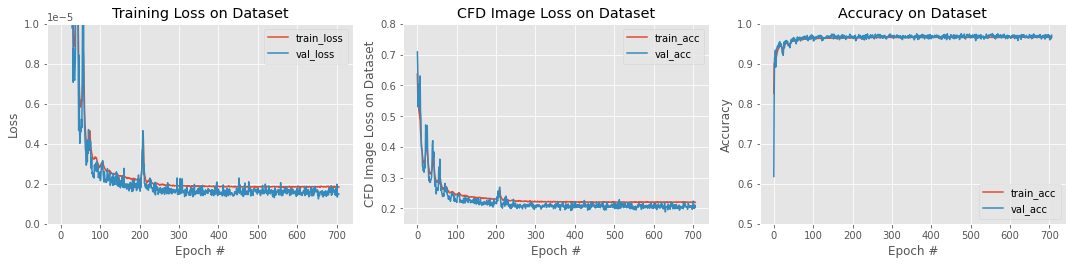

In [ ]:
N = count
# plot training and validation accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 4))
ax1.plot(np.arange(0, N), history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), history["val_loss"], label="val_loss")
ax1.set_title("Training Loss on Dataset")
ax1.set_xlabel("Epoch #")
ax1.set_ylim(0.0, 1e-5)
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

ax2.plot(np.arange(0, N), history["cfd_image"], label="train_acc")
ax2.plot(np.arange(0, N), history["val_cfd_image"], label="val_acc")
ax2.set_title("CFD Image Loss on Dataset")
ax2.set_xlabel("Epoch #")
ax2.set_ylim(0.15, 0.80)
ax2.set_ylabel("CFD Image Loss on Dataset")
ax2.legend(loc="upper right")

ax3.plot(np.arange(0, N), history["accuracy"], label="train_acc")
ax3.plot(np.arange(0, N), history["val_accuracy"], label="val_acc")
ax3.set_title("Accuracy on Dataset")
ax3.set_xlabel("Epoch #")
ax3.set_ylim(0.5, 1)
ax3.set_ylabel("Accuracy")
plt.legend(loc="lower right")


plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=0.85)
plt.savefig(args["plots"] + "all_history.png")
plt.show()

In [ ]:
# plot the learning rate history
#N = np.arange(0, len(clr.history["lr"]))
#plt.figure()
#plt.plot(N, clr.history["lr"])
#plt.title("Cyclical Learning Rate (CLR)")
#plt.xlabel("Training Iterations")
#plt.ylabel("Learning Rate")
#CLR_PLOT_PATH = os.path.sep.join(["plots", "CLR_PLOT_PATH.png"])
#plt.savefig(CLR_PLOT_PATH)

In [ ]:
 boundary, sflow = next(iter(test_dataset))
 DESIRED_ACCURACY = 0.979

#class myCallback(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epochs, logs={}) :
#        if(logs.get('acc') is not None and logs.get('acc') >= DESIRED_ACCURACY) :
#            print('\nReached 99.9% accuracy so cancelling training!')
#            self.model.stop_training = True
#
#callbacks = myCallback()
#preds = model.predict(test_dataset.take(1))
model.evaluate(test_dataset)